In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm


os.chdir("..")
from src.data_correction import dilution_factor_correction

In [2]:
# load data
online_dat_filepath = os.path.join('data', 'COU_S2_004_RL_Repeat_processed.csv')
online_dat = pd.read_csv(online_dat_filepath, index_col=0)

## wells in row F were only sampled in the end and in row E sampled twice
online_dat['Biolector row'] = online_dat['Biolector well'].str.extract(r"([A-Z])")
online_dat['Biolector column'] = online_dat['Biolector well'].str.extract(r"(\d.*)")
online_dat.head()


,Biolector well,Cycle,Accum. feed [uL],Time,Volume,Biomass [LS Gain=3],DO%,pH,Feeding,Feeding time,Biolector row,Biolector column
0,C01,0.0,0.0,0.0028,800.0,1.98,86.010002,5.84,False,-14.3,C,01
1,C02,0.0,0.0,0.0028,800.0,1.94,89.400002,5.85,False,-14.3,C,02
2,C03,0.0,0.0,0.0028,800.0,1.97,92.139999,5.84,False,-14.3,C,03
3,C04,0.0,0.0,0.0028,800.0,1.94,90.769997,5.87,False,-14.3,C,04
4,C05,0.0,0.0,0.0028,800.0,2.10,91.120003,5.88,False,-14.3,C,05


In [3]:
# loading sampling data
sample_dat_filepath = os.path.join('data', 'Ct000259.LG_Pipetting_processed.csv')
sample_dat = pd.read_csv(sample_dat_filepath, index_col=0)
sample_dat.head()

,Date,Time [h],Cycle,Biolector well,Trigger,Source,Destination,Sample volume,Mode,Tip,Sampling round,Sample ID
0,03-03-2022,"41,0586111111111",411,C01,Sample1 (Abs.Time [h]),BioLector:C01,Slot3:1,300,Sampling,Fixed,1,CFB5-S1-D3:1-U1
1,03-03-2022,"41,0586111111111",411,C02,Sample1 (Abs.Time [h]),BioLector:C02,Slot3:2,300,Sampling,Fixed,1,CFB5-S1-D3:2-U1
2,03-03-2022,"41,0586111111111",411,C03,Sample1 (Abs.Time [h]),BioLector:C03,Slot3:3,300,Sampling,Fixed,1,CFB5-S1-D3:3-U1
3,03-03-2022,"41,0586111111111",411,C04,Sample1 (Abs.Time [h]),BioLector:C04,Slot3:4,300,Sampling,Fixed,1,CFB5-S1-D3:4-U1
4,03-03-2022,"41,0586111111111",411,C05,Sample1 (Abs.Time [h]),BioLector:C05,Slot3:5,300,Sampling,Fixed,1,CFB5-S1-D3:5-U1


In [4]:
# merge datasets
df = (online_dat
    .merge(sample_dat, on = ['Biolector well', 'Cycle'], how='left', validate='1:1')
    .assign(ls_mass = lambda df: df["Biomass [LS Gain=3]"] * df["Volume"])
)
df['Sample volume'] = df['Sample volume'].fillna(0)

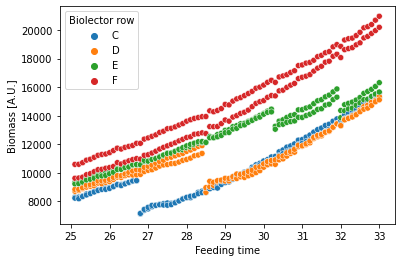

In [5]:
# plotting
use_columns = ['01', '02']
plot_dat = (df
    .query("Feeding == True & `Feeding time` > 25 &  `Feeding time` < 33 & `Biolector column`.isin(@use_columns)")
    .assign(ls_mass = lambda df: df["Biomass [LS Gain=3]"] * df["Volume"])
)

sns.scatterplot(data=plot_dat, x='Feeding time', y='ls_mass', hue='Biolector row')
plt.ylabel('Biomass [A.U.]')
plt.savefig('./reports/figures/real-data-overview.png', dpi=300)

In [6]:
# check that the volume column contain aftersample volumes
df.groupby('Biolector well').apply(lambda x: (x['Volume'] + x['Sample volume']) / x['Volume'].shift())

Biolector well       
C01             0        NaN
                32       1.0
                64       1.0
                96       1.0
                128      1.0
                        ... 
F08             22239    1.0
                22271    1.0
                22303    1.0
                22335    1.0
                22367    1.0
Length: 22368, dtype: float64

In [7]:
from src.data_correction import pseudobatch_transform 
#df['biomass_pseudo'] = 
df = (df
    .groupby("Biolector well")
    .apply(lambda g: g.assign(biomass_pseudo = lambda grp: pseudobatch_transform(
            grp['Biomass [LS Gain=3]'].to_numpy(),
            (grp['Volume'] + grp['Sample volume'].fillna(0)).to_numpy(),
            grp['Accum. feed [uL]'].to_numpy(),
            0,
            grp['Sample volume'].fillna(0)
        ))
    )
    
)


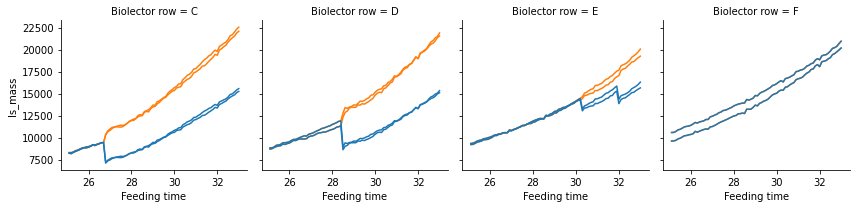

In [8]:
plot_dat = (df
    .query("Feeding == True & `Feeding time` > 25 &  `Feeding time` < 33 & `Biolector column`.isin(@use_columns)")
    .assign(ls_mass_pseudo = lambda df: df["biomass_pseudo"] * 800)
)
g = sns.FacetGrid(data = plot_dat, col = 'Biolector row')
g.map_dataframe(sns.lineplot, x='Feeding time', y='ls_mass_pseudo', units='Biolector well', estimator=None, color='tab:orange')
g.map_dataframe(sns.lineplot, x='Feeding time', y='ls_mass', units='Biolector well', estimator=None)

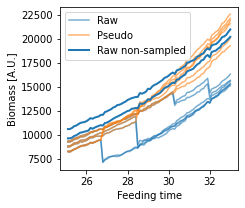

In [9]:
sns.lineplot(data=plot_dat.query("`Biolector row` != 'F'"), x='Feeding time', y='ls_mass', units='Biolector well', estimator=None, color='tab:blue', alpha=0.6, label='Raw')
sns.lineplot(data=plot_dat.query("`Biolector row` != 'F'"), x='Feeding time', y='ls_mass_pseudo', units='Biolector well', estimator=None, color='tab:orange', alpha=0.6, label='Pseudo')
sns.lineplot(data=plot_dat.query("`Biolector row` == 'F'"), x='Feeding time', y='ls_mass', units='Biolector well', estimator=None, color='tab:blue', linewidth = 2, label='Raw non-sampled')

# drop duplicated labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.ylabel('Biomass [A.U.]')
plt.savefig('./reports/figures/real-data-compare.png', dpi=300)

fig = plt.gcf()
fig.set_size_inches((3.2, 3))
fig.savefig('./reports/figures/real-data-compare-paper.png', dpi=300)

Text(0, 0.5, 'Biomass [A.U.]')

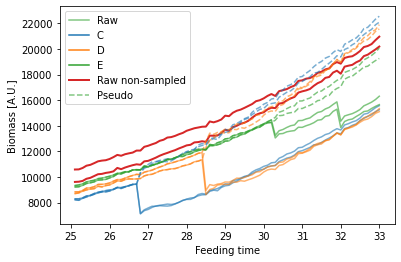

In [10]:
sns.lineplot(data=plot_dat.query("`Biolector row` != 'F'"), x='Feeding time', y='ls_mass', units='Biolector well', estimator=None, alpha=0.6, hue='Biolector row', label='Raw')
sns.lineplot(data=plot_dat.query("`Biolector row` == 'F'"), x='Feeding time', y='ls_mass', units='Biolector well', estimator=None, color='tab:red', linewidth = 2, label='Raw non-sampled')
sns.lineplot(data=plot_dat.query("`Biolector row` != 'F'"), x='Feeding time', y='ls_mass_pseudo', units='Biolector well', estimator=None, hue='Biolector row', alpha=0.6, label='Pseudo', linestyle='--')

# drop duplicated labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.ylabel('Biomass [A.U.]')
#plt.savefig('./reports/figures/real-data-compare.png', dpi=300)

In [11]:
df['mu_hat'] = (df
    .groupby('Biolector well')
    .apply(lambda x: np.gradient(x['biomass_pseudo'], x['Time'])/ x['biomass_pseudo'])
    .reset_index(0, drop=True)
)

(0.0, 40.0)

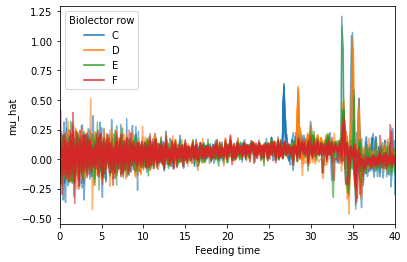

In [12]:
sns.lineplot(data=df, x='Feeding time', y='mu_hat', units='Biolector well', estimator=None, alpha=0.6, hue='Biolector row')
plt.xlim((0, 40))

mu_hat                    
                    mean    median       std
Biolector well                              
C01             0.069316  0.075106  0.089609
C02             0.068920  0.079468  0.097019
C03             0.069579  0.074206  0.078581
C04             0.068937  0.067305  0.087609
C05             0.064168  0.069212  0.081024
C06             0.059919  0.064266  0.081740
C07             0.061710  0.063281  0.076532
C08             0.061963  0.059499  0.069804
D01             0.065244  0.066369  0.097468
D02             0.064091  0.068964  0.080601
D03             0.064171  0.071398  0.082588
D04             0.064303  0.067937  0.077266
D05             0.060914  0.066311  0.076848
D06             0.062978  0.072826  0.058471
D07             0.057924  0.056634  0.067883
D08             0.057478  0.058825  0.064322
E01             0.058237  0.068215  0.068874
E02             0.059496  0.069718  0.068727
E03             0.059917  0.069551  0.063619
E04             0.059227  0.067494  0.058373
E05             0.055939  0.066387  0.063391
E06             0.048196  0.061827  0.065516
E07             0.053784  0.055602  0.054127
E08             0.054340  0.055792  0.054184
F01             0.060121  0.068198  0.079632
F02             0.061156  0.069502  0.065129
F03             0.057450  0.066326  0.064745
F04             0.059740  0.069288  0.061661
F05             0.055971  0.060462  0.058492
F06             0.051325  0.059291  0.063288
F07             0.052322  0.058349  0.060713
F08             0.053116  0.055678  0.040407

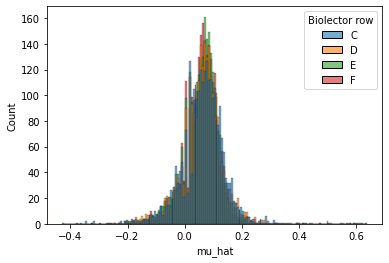

In [13]:
sns.histplot(data=df.query("`Feeding time` > 0 & `Feeding time` < 33"), x='mu_hat', alpha=0.6, hue='Biolector row')

(df
    .query("`Feeding time` > 0 & `Feeding time` < 33")
    .filter(['Biolector well', 'mu_hat'])
    .groupby('Biolector well')
    .agg(['mean', 'median', 'std'])
)